## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_l1l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio,l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio,l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 109us/step - loss: 6.0061 - acc: 0.2769 - val_loss: 5.8050 - val_acc: 0.3439
Epoch 2/50
50000/50000 [==============================] - 5s 97us/step - loss: 5.7027 - acc: 0.3704 - val_loss: 5.6266 - val_acc: 0.3818
Epoch 3/50
50000/50000 [==============================] - 6s 115us/step - loss: 5.5593 - acc: 0.4007 - val_loss: 5.4972 - val_acc: 0.4101
Epoch 4/50
50000/50000 [==============================] - 6s 118us/step - loss: 5.4396 - acc: 0.4207 - val_loss: 5.3831 - val_acc: 0.4325
Epoch 5/50
50000/50000 [==============================] - 5s 99us/step - loss: 5.3298 - acc: 0.4363 - val_loss: 5.2952 - val_acc: 0.4354
Epoch 6/50
50000/50000 [==============================] - 5s 92us/step - loss: 5.2275 - acc: 0.4505 - val_loss: 5.1911 - val_acc: 0.4477
Epoch 7/50
50000/50000 [==============================] - 4s 88us/step - loss: 5.1336 - acc: 0.4625 - val_loss: 5.1056 - val_

50000/50000 [==============================] - 5s 97us/step - loss: 1.7178 - acc: 0.3982 - val_loss: 1.6925 - val_acc: 0.4069
Epoch 4/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.6598 - acc: 0.4178 - val_loss: 1.6340 - val_acc: 0.4223
Epoch 5/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.6122 - acc: 0.4349 - val_loss: 1.5942 - val_acc: 0.4396
Epoch 6/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.5730 - acc: 0.4480 - val_loss: 1.5647 - val_acc: 0.4490
Epoch 7/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.5386 - acc: 0.4615 - val_loss: 1.5464 - val_acc: 0.4544
Epoch 8/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.5098 - acc: 0.4711 - val_loss: 1.5333 - val_acc: 0.4553
Epoch 9/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.4817 - acc: 0.4781 - val_loss: 1.5070 - val_acc: 0.4665
Epoch 10/50
50000/50000 [===========================

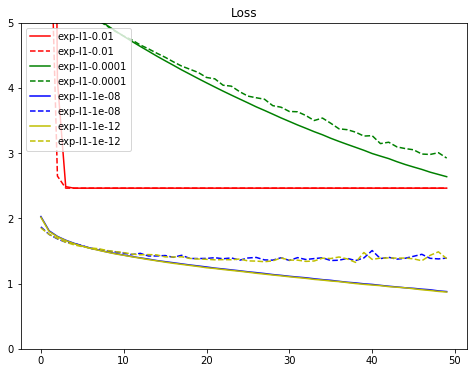

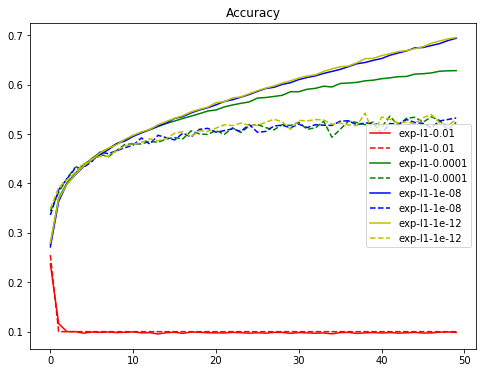

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k", "gray", "tan", "skyblue"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [12]:
results = {}
for l1_ratio in L1_EXP:
    for l2_ratio in L2_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("L1 = %.6f, L2 = %.6f" % (l1_ratio,l2_ratio))
        model = build_mlp_l1l2(input_shape=x_train.shape[1:], l1_ratio=l1_ratio, l2_ratio=l2_ratio)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-L1: %s L2: %s" % (str(l1_ratio),str(l2_ratio))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

L1 = 0.010000, L2 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=============================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 114us/step - loss: 198.7111 - acc: 0.2487 - val_loss: 41.1931 - val_acc: 0.2741
Epoch 2/50
50000/50000 [==============================] - 4s 88us/step - loss: 19.1487 - acc: 0.1186 - val_loss: 7.3053 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 4s 89us/step - loss: 4.1179 - acc: 0.0984 - val_loss: 2.6483 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.4862 - acc: 0.0977 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.4626 - acc: 0.0985 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.4626 - acc: 0.0989 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.4626 - acc: 0.0973 - val_loss: 2.4625 - va

50000/50000 [==============================] - 5s 94us/step - loss: 19.1549 - acc: 0.1206 - val_loss: 7.3208 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 5s 91us/step - loss: 4.1247 - acc: 0.0984 - val_loss: 2.6505 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.4862 - acc: 0.0961 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 5s 92us/step - loss: 2.4626 - acc: 0.0980 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 5s 99us/step - loss: 2.4626 - acc: 0.0980 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 5s 92us/step - loss: 2.4626 - acc: 0.0982 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 5s 93us/step - loss: 2.4626 - acc: 0.0966 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 9/50
50000/50000 [===========================

50000/50000 [==============================] - 5s 101us/step - loss: 4.1032 - acc: 0.0970 - val_loss: 2.6487 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.4866 - acc: 0.0986 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 5s 93us/step - loss: 2.4626 - acc: 0.0977 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.4626 - acc: 0.0973 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 5s 91us/step - loss: 2.4626 - acc: 0.1000 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 5s 90us/step - loss: 2.4626 - acc: 0.0985 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 5s 91us/step - loss: 2.4626 - acc: 0.0983 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 10/50
50000/50000 [=========================

50000/50000 [==============================] - 5s 99us/step - loss: 12.0936 - acc: 0.3938 - val_loss: 11.2607 - val_acc: 0.4018: 12.1368 - a
Epoch 5/50
50000/50000 [==============================] - 5s 95us/step - loss: 10.5241 - acc: 0.4044 - val_loss: 9.8169 - val_acc: 0.4036
Epoch 6/50
50000/50000 [==============================] - 5s 91us/step - loss: 9.1885 - acc: 0.4107 - val_loss: 8.5839 - val_acc: 0.4151
Epoch 7/50
50000/50000 [==============================] - 5s 93us/step - loss: 8.0518 - acc: 0.4169 - val_loss: 7.5402 - val_acc: 0.4176
Epoch 8/50
50000/50000 [==============================] - 5s 94us/step - loss: 7.0829 - acc: 0.4200 - val_loss: 6.6437 - val_acc: 0.4254
Epoch 9/50
50000/50000 [==============================] - 5s 92us/step - loss: 6.2577 - acc: 0.4255 - val_loss: 5.8879 - val_acc: 0.4281
Epoch 10/50
50000/50000 [==============================] - 5s 96us/step - loss: 5.5550 - acc: 0.4303 - val_loss: 5.2415 - val_acc: 0.4234
Epoch 11/50
50000/50000 [==========

50000/50000 [==============================] - 5s 97us/step - loss: 5.4601 - acc: 0.4282 - val_loss: 5.4242 - val_acc: 0.4302
Epoch 6/50
50000/50000 [==============================] - 4s 89us/step - loss: 5.3539 - acc: 0.4421 - val_loss: 5.3110 - val_acc: 0.4427
Epoch 7/50
50000/50000 [==============================] - 4s 89us/step - loss: 5.2542 - acc: 0.4529 - val_loss: 5.2255 - val_acc: 0.4534
Epoch 8/50
50000/50000 [==============================] - 5s 100us/step - loss: 5.1588 - acc: 0.4632 - val_loss: 5.1250 - val_acc: 0.4631
Epoch 9/50
50000/50000 [==============================] - 5s 99us/step - loss: 5.0673 - acc: 0.4708 - val_loss: 5.0547 - val_acc: 0.4613
Epoch 10/50
50000/50000 [==============================] - 5s 94us/step - loss: 4.9794 - acc: 0.4803 - val_loss: 4.9682 - val_acc: 0.4662
Epoch 11/50
50000/50000 [==============================] - 5s 92us/step - loss: 4.8925 - acc: 0.4881 - val_loss: 4.8871 - val_acc: 0.4728
Epoch 12/50
50000/50000 [========================

50000/50000 [==============================] - 5s 91us/step - loss: 5.2244 - acc: 0.4507 - val_loss: 5.1860 - val_acc: 0.4517
Epoch 7/50
50000/50000 [==============================] - 5s 91us/step - loss: 5.1299 - acc: 0.4634 - val_loss: 5.1097 - val_acc: 0.4472
Epoch 8/50
50000/50000 [==============================] - 5s 94us/step - loss: 5.0407 - acc: 0.4710 - val_loss: 5.0163 - val_acc: 0.4662
Epoch 9/50
50000/50000 [==============================] - 5s 93us/step - loss: 4.9549 - acc: 0.4813 - val_loss: 4.9401 - val_acc: 0.4677
Epoch 10/50
50000/50000 [==============================] - 5s 93us/step - loss: 4.8694 - acc: 0.4898 - val_loss: 4.8656 - val_acc: 0.4778
Epoch 11/50
50000/50000 [==============================] - 5s 97us/step - loss: 4.7885 - acc: 0.4954 - val_loss: 4.7921 - val_acc: 0.4819
Epoch 12/50
50000/50000 [==============================] - 5s 94us/step - loss: 4.7082 - acc: 0.5033 - val_loss: 4.7283 - val_acc: 0.4799
Epoch 13/50
50000/50000 [========================

Epoch 8/50
50000/50000 [==============================] - 5s 92us/step - loss: 5.0638 - acc: 0.4658 - val_loss: 5.0519 - val_acc: 0.4530
Epoch 9/50
50000/50000 [==============================] - 5s 94us/step - loss: 4.9774 - acc: 0.4741 - val_loss: 4.9673 - val_acc: 0.4595
Epoch 10/50
50000/50000 [==============================] - 5s 92us/step - loss: 4.8940 - acc: 0.4803 - val_loss: 4.8852 - val_acc: 0.4716
Epoch 11/50
50000/50000 [==============================] - 5s 98us/step - loss: 4.8131 - acc: 0.4890 - val_loss: 4.8178 - val_acc: 0.4700
Epoch 12/50
50000/50000 [==============================] - 5s 98us/step - loss: 4.7329 - acc: 0.4960 - val_loss: 4.7390 - val_acc: 0.4736
Epoch 13/50
50000/50000 [==============================] - 5s 94us/step - loss: 4.6544 - acc: 0.5027 - val_loss: 4.6649 - val_acc: 0.4840
Epoch 14/50
50000/50000 [==============================] - 5s 102us/step - loss: 4.5783 - acc: 0.5092 - val_loss: 4.5918 - val_acc: 0.4882.5815 - ac
Epoch 15/50
50000/50000 [

50000/50000 [==============================] - 4s 89us/step - loss: 5.4459 - acc: 0.4338 - val_loss: 5.1789 - val_acc: 0.4260
Epoch 10/50
50000/50000 [==============================] - 4s 90us/step - loss: 4.9042 - acc: 0.4391 - val_loss: 4.6633 - val_acc: 0.4409
Epoch 11/50
50000/50000 [==============================] - 4s 90us/step - loss: 4.4399 - acc: 0.4441 - val_loss: 4.2623 - val_acc: 0.4335
Epoch 12/50
50000/50000 [==============================] - 4s 89us/step - loss: 4.0427 - acc: 0.4488 - val_loss: 3.8746 - val_acc: 0.4440
Epoch 13/50
50000/50000 [==============================] - 4s 90us/step - loss: 3.7046 - acc: 0.4520 - val_loss: 3.5854 - val_acc: 0.4412
Epoch 14/50
50000/50000 [==============================] - 5s 92us/step - loss: 3.4135 - acc: 0.4551 - val_loss: 3.2952 - val_acc: 0.4442
Epoch 15/50
50000/50000 [==============================] - 5s 93us/step - loss: 3.1643 - acc: 0.4587 - val_loss: 3.0587 - val_acc: 0.4531
Epoch 16/50
50000/50000 [=====================

50000/50000 [==============================] - 5s 98us/step - loss: 1.6052 - acc: 0.4867 - val_loss: 1.6264 - val_acc: 0.4731
Epoch 11/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.5812 - acc: 0.4929 - val_loss: 1.6220 - val_acc: 0.4744
Epoch 12/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.5599 - acc: 0.5030 - val_loss: 1.6084 - val_acc: 0.4867
Epoch 13/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.5363 - acc: 0.5107 - val_loss: 1.5854 - val_acc: 0.4889
Epoch 14/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.5191 - acc: 0.5158 - val_loss: 1.5912 - val_acc: 0.4835
Epoch 15/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.4983 - acc: 0.5232 - val_loss: 1.5689 - val_acc: 0.4929
Epoch 16/50
50000/50000 [==============================] - 5s 100us/step - loss: 1.4793 - acc: 0.5289 - val_loss: 1.5560 - val_acc: 0.4984
Epoch 17/50
50000/50000 [=================

50000/50000 [==============================] - 5s 103us/step - loss: 1.4415 - acc: 0.4953 - val_loss: 1.4823 - val_acc: 0.4692
Epoch 12/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.4210 - acc: 0.5029 - val_loss: 1.4606 - val_acc: 0.4830
Epoch 13/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.3997 - acc: 0.5093 - val_loss: 1.4681 - val_acc: 0.4750
Epoch 14/50
50000/50000 [==============================] - 5s 94us/step - loss: 1.3789 - acc: 0.5170 - val_loss: 1.4403 - val_acc: 0.4872
Epoch 15/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.3594 - acc: 0.5214 - val_loss: 1.4237 - val_acc: 0.4953
Epoch 16/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.3422 - acc: 0.5274 - val_loss: 1.4183 - val_acc: 0.4999
Epoch 17/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.3258 - acc: 0.5347 - val_loss: 1.4440 - val_acc: 0.4939
Epoch 18/50
50000/50000 [==================

50000/50000 [==============================] - 5s 102us/step - loss: 1.4125 - acc: 0.5037 - val_loss: 1.4747 - val_acc: 0.4788
Epoch 13/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.3929 - acc: 0.5114 - val_loss: 1.4379 - val_acc: 0.4943
Epoch 14/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.3704 - acc: 0.5186 - val_loss: 1.4609 - val_acc: 0.4777
Epoch 15/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.3546 - acc: 0.5239 - val_loss: 1.4221 - val_acc: 0.4954
Epoch 16/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.3350 - acc: 0.5322 - val_loss: 1.4089 - val_acc: 0.5032
Epoch 17/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.3157 - acc: 0.5355 - val_loss: 1.3964 - val_acc: 0.5036
Epoch 18/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.2991 - acc: 0.5441 - val_loss: 1.3994 - val_acc: 0.4923
Epoch 19/50
50000/50000 [==============

50000/50000 [==============================] - 5s 98us/step - loss: 3.7104 - acc: 0.4496 - val_loss: 3.5718 - val_acc: 0.4403
Epoch 14/50
50000/50000 [==============================] - 5s 99us/step - loss: 3.4202 - acc: 0.4522 - val_loss: 3.3006 - val_acc: 0.4466
Epoch 15/50
50000/50000 [==============================] - 5s 103us/step - loss: 3.1718 - acc: 0.4531 - val_loss: 3.0646 - val_acc: 0.4557
Epoch 16/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.9553 - acc: 0.4592 - val_loss: 2.8676 - val_acc: 0.4548
Epoch 17/50
50000/50000 [==============================] - 5s 107us/step - loss: 2.7737 - acc: 0.4617 - val_loss: 2.6969 - val_acc: 0.4609
Epoch 18/50
50000/50000 [==============================] - 6s 118us/step - loss: 2.6158 - acc: 0.4639 - val_loss: 2.5648 - val_acc: 0.4630
Epoch 19/50
50000/50000 [==============================] - 5s 93us/step - loss: 2.4809 - acc: 0.4674 - val_loss: 2.4290 - val_acc: 0.4632
Epoch 20/50
50000/50000 [=================

50000/50000 [==============================] - 5s 99us/step - loss: 1.5114 - acc: 0.5196 - val_loss: 1.5658 - val_acc: 0.4929
Epoch 15/50
50000/50000 [==============================] - 5s 94us/step - loss: 1.4916 - acc: 0.5244 - val_loss: 1.5594 - val_acc: 0.4942
Epoch 16/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.4712 - acc: 0.5327 - val_loss: 1.5751 - val_acc: 0.4878
Epoch 17/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.4559 - acc: 0.5377 - val_loss: 1.5893 - val_acc: 0.4938
Epoch 18/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.4362 - acc: 0.5440 - val_loss: 1.5305 - val_acc: 0.5069
Epoch 19/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.4201 - acc: 0.5490 - val_loss: 1.5968 - val_acc: 0.4917
Epoch 20/50
50000/50000 [==============================] - 5s 94us/step - loss: 1.4060 - acc: 0.5544 - val_loss: 1.5260 - val_acc: 0.5124
Epoch 21/50
50000/50000 [====================

50000/50000 [==============================] - 5s 100us/step - loss: 1.3390 - acc: 0.5276 - val_loss: 1.4140 - val_acc: 0.5010
Epoch 16/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.3201 - acc: 0.5345 - val_loss: 1.4128 - val_acc: 0.5019
Epoch 17/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.3023 - acc: 0.5417 - val_loss: 1.4063 - val_acc: 0.4977
Epoch 18/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.2843 - acc: 0.5476 - val_loss: 1.3954 - val_acc: 0.5035
Epoch 19/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.2688 - acc: 0.5537 - val_loss: 1.3884 - val_acc: 0.5073
Epoch 20/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.2539 - acc: 0.5578 - val_loss: 1.3667 - val_acc: 0.5196
Epoch 21/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.2360 - acc: 0.5648 - val_loss: 1.3685 - val_acc: 0.5119
Epoch 22/50
50000/50000 [===============

50000/50000 [==============================] - 4s 90us/step - loss: 1.3311 - acc: 0.5334 - val_loss: 1.4564 - val_acc: 0.4848
Epoch 17/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.3135 - acc: 0.5395 - val_loss: 1.4145 - val_acc: 0.5005
Epoch 18/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.2974 - acc: 0.5444 - val_loss: 1.3946 - val_acc: 0.5001
Epoch 19/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.2781 - acc: 0.5518 - val_loss: 1.3906 - val_acc: 0.5033
Epoch 20/50
50000/50000 [==============================] - 5s 96us/step - loss: 1.2627 - acc: 0.5577 - val_loss: 1.4276 - val_acc: 0.4891
Epoch 21/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.2478 - acc: 0.5620 - val_loss: 1.3808 - val_acc: 0.5076
Epoch 22/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.2338 - acc: 0.5650 - val_loss: 1.3900 - val_acc: 0.5074
Epoch 23/50
50000/50000 [===================

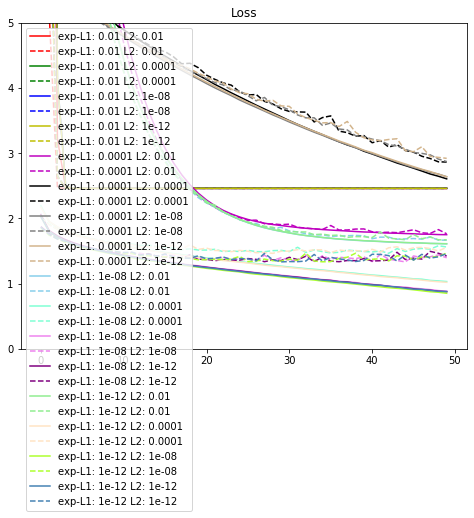

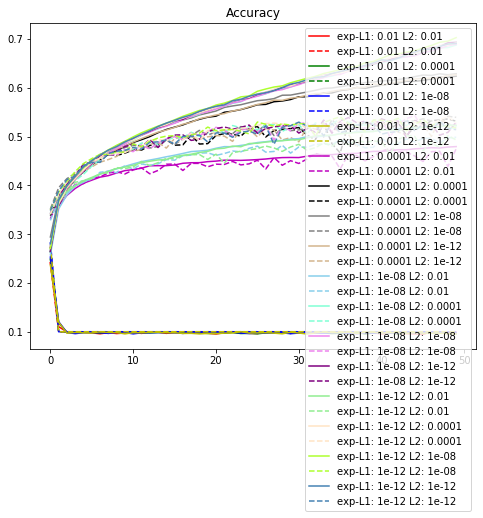

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k", "gray", "tan", "skyblue", "aquamarine", "violet", "purple", "lightgreen", "bisque", "greenyellow", "steelblue"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()